# Investment Strategy

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.15)
import warnings; warnings.filterwarnings('ignore')
from IPython.display import Markdown, display, SVG
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, RidgeCV, LassoCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from graphviz import Source
pd.options.display.max_rows = 50
pd.options.display.max_columns = 50
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams['figure.figsize'] = (12, 4)

In [2]:
#LOAD LOANSTATS
directory = '../../data/'
ls = pd.read_hdf(directory + 'ls_CLEAN.h5', 'ls_CLEAN')
ls.sort_index(axis=1, inplace=True)

In [3]:
def model_scoring(model, feature, target, modeltype='C', cv=5):
    """Displays model evaluation for regression and classification modeling"""
    scores = ['accuracy', 'precision', 'recall']
    if modeltype=='R': # regression
        scores = ['neg_mean_squared_error', 'r2']
    for score in scores:
        cv_score = cross_val_score(model, feature, target, scoring=score, cv=cv).mean()
        print('\tCross-validation {}: {:.4}'.format(score, cv_score))

In [4]:
from sklearn.model_selection import train_test_split
ls_train, ls_test = train_test_split(ls, test_size=0.2, stratify=ls['OUT_Class'], random_state=1)

In [5]:
#STANDARD SCALING
scaler = StandardScaler()

#separate features and targets
outcome_var_list = sorted(out_var for out_var in ls.columns if "OUT_" in out_var)

#train features
X_train = ls_train[sorted(set(ls.columns)-set(outcome_var_list))]
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),index=X_train.index, columns=X_train.columns)

#test features
X_test = ls_test[sorted(set(ls.columns)-set(outcome_var_list))]
X_test_scaled = pd.DataFrame(scaler.transform(X_test),index=X_test.index, columns=X_test.columns)

#train targets
y_train = ls_train[sorted(outcome_var_list)]
OUT_Class_train = y_train.iloc[:,0]
OUT_Principle_Repaid_Percentage_train = y_train.iloc[:,1]
OUT_Monthly_Rate_Of_Return_train = y_train.iloc[:,2]

#test targets
y_test = ls_test[sorted(outcome_var_list)]
OUT_Class_test = y_test.iloc[:,0]
OUT_Principle_Repaid_Percentage_test = y_test.iloc[:,1]
OUT_Monthly_Rate_Of_Return_test = y_test.iloc[:,2]

In [6]:
#GET POLYNOMIALS
dummy_var_list = sorted(dummy for dummy in ls.columns if "D_" in dummy)
numeric_var_list = sorted(set(ls.columns) - set(outcome_var_list) - set(dummy_var_list))
poly_2 = pd.DataFrame(np.hstack((X_train.iloc[:,22:]**(i+1) for i in range(2))),
                      index=X_train.index, 
                      columns=numeric_var_list+[s+'_2' for s in numeric_var_list])
X_train_2 = pd.concat([ls_train[dummy_var_list], poly_2], axis=1).sort_index(axis=1)
poly_2 = pd.DataFrame(np.hstack((X_test.iloc[:,22:]**(i+1) for i in range(2))),
                      index=X_test.index, 
                      columns=numeric_var_list+[s+'_2' for s in numeric_var_list])
X_test_2 = pd.concat([ls_test[dummy_var_list], poly_2], axis=1).sort_index(axis=1)

#STANDARD SCALING
scaler = StandardScaler()
X_train_scaled_2 = pd.DataFrame(scaler.fit_transform(X_train_2),index=X_train_2.index, columns=X_train_2.columns)
X_test_scaled_2 = pd.DataFrame(scaler.transform(X_test_2),index=X_test_2.index, columns=X_test_2.columns)

In [7]:
#CLASSIFIERS
dummy_cls = DummyClassifier(strategy='uniform', random_state=1)
dummy_cls.fit(X_train_scaled, OUT_Class_train)
log_cls = LogisticRegressionCV(Cs=8, solver='lbfgs', max_iter=10000, class_weight='balanced', random_state=0, fit_intercept=False)
log_cls.fit(X_train_scaled, OUT_Class_train)

#REGRESSORS PRP
ridge_reg_PRP = RidgeCV(fit_intercept=False)
ridge_reg_PRP.fit(X_train_scaled, OUT_Principle_Repaid_Percentage_train)
lasso_reg_PRP = LassoCV(fit_intercept=False)
lasso_reg_PRP.fit(X_train_scaled, OUT_Principle_Repaid_Percentage_train)
lasso_reg2_PRP = LassoCV(fit_intercept=False)
lasso_reg2_PRP.fit(X_train_scaled_2, OUT_Principle_Repaid_Percentage_train)

#REGRESSORS MRR
ridge_reg_MRR = RidgeCV(fit_intercept=False)
ridge_reg_MRR.fit(X_train_scaled, OUT_Monthly_Rate_Of_Return_train)
lasso_reg_MRR = LassoCV(fit_intercept=False)
lasso_reg_MRR.fit(X_train_scaled, OUT_Monthly_Rate_Of_Return_train)
lasso_reg2_MRR = LassoCV(fit_intercept=False)
lasso_reg2_MRR.fit(X_train_scaled_2,OUT_Monthly_Rate_Of_Return_train)
x=0

## 1. Modeling Summary

In [8]:
results = pd.read_excel(directory + 'ModelResults.xlsx', sheet_name=[0,1,2], header=[0,1])
OUT_Class_results = results[0]
OUT_PRP_results = results[1]
OUT_MRR_results = results[2]

In the [Modeling](https://cs109group67.github.io/lendingclub/Modeling.html) section we preformed a variety of classifiction and regression models on the three outcome features. A summary of the model scoring metrics is as follows:

In [9]:
display(Markdown('**`OUT_Class`:**'))
OUT_Class_results

**`OUT_Class`:**

Model               Training Scores                  Testing Scores            \
                           Accuracy Precision Recall       Accuracy Precision   
Baseline Classifier           0.502     0.864  0.502          0.501     0.864   
Logistic Classifier           0.565     0.926  0.540          0.565     0.925   

Model                       
                    Recall  
Baseline Classifier  0.502  
Logistic Classifier  0.541

In [10]:
display(Markdown('**`OUT_Principle_Repaid`:**'))
OUT_PRP_results

**`OUT_Principle_Repaid`:**

Model                Training Scores        Testing Scores       
                             Neg MSE     R2        Neg MSE     R2
Baseline Regressor            -0.002 -0.000         -0.002 -0.000
Linear Regressor              -0.002  0.007         -0.002  0.005
Ridge Regressor               -0.002  0.007         -0.002  0.006
Lasso Regressor               -0.002  0.008         -0.002  0.006
Polynomial Regressor          -0.002  0.009         -0.002  0.006

In [11]:
display(Markdown('**`OUT_Monthly_Rate_Of_Return`:**'))
OUT_MRR_results

**`OUT_Monthly_Rate_Of_Return`:**

Model                Training Scores           Testing Scores        
                             Neg MSE        R2        Neg MSE      R2
Baseline Regressor            -0.047    -0.000         -0.047  -0.000
Linear Regressor              -0.998   -20.427         -0.950 -19.218
Ridge Regressor               -0.921   -18.730         -0.895 -18.010
Lasso Regressor               -0.895   -18.170         -0.894 -17.993
Polynomial Regressor        -305.134 -6566.432         -0.676 -13.230

The classification and regression models did not perform well at predicting the target features, but they did provide important information about which variables potentially hold the most inferential information for a prospective investor. The visualizations below display cofficients assigned across the models. The focus is on features that have the most significant magnitude across distinct models.

In [12]:
def plot_coefficients(feature_train, models, title, thresh=(0.0025,4), figsize=(10,4)):
    """Plots the coefficients assigned by the model to each feature"""
    # create DataFrame with coefficient names and values 
    names = feature_train.columns.tolist()
    coefs = pd.DataFrame(names, columns=['coefs'])
    for k,m in models.items():
        coefs[k] = m.coef_.flatten()
    coefs = coefs.sort_values(by='coefs', ascending=False)

    # plot coefficients for each feature
    coefs = coefs[(coefs > thresh[0]) | (coefs < -thresh[0])]
    coefs.sort_index(inplace=True, ascending=False)
    coefs.dropna(thresh=thresh[1], inplace=True)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    for k,m in models.items():
        ax.scatter(coefs[k], coefs['coefs'], alpha=0.5, label=k, s=80)
    ax.legend(fontsize=10)
    ax.set_xlabel('Coefficient Value')
    ax.set_ylabel('Features')
    ax.set_title('Coefficients Assigned Across the {}'.format(title))
    ax.axvline(0, color='black')
    plt.show()
    return coefs

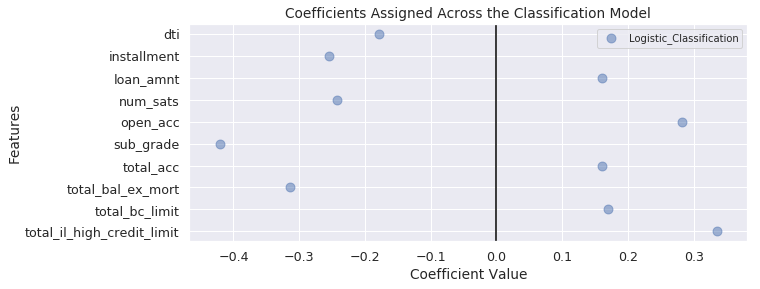

In [13]:
models = dict(Logistic_Classification=log_cls,)
coefs1 = plot_coefficients(X_train_scaled, models=models, thresh=(0.15,2), title='Classification Model')

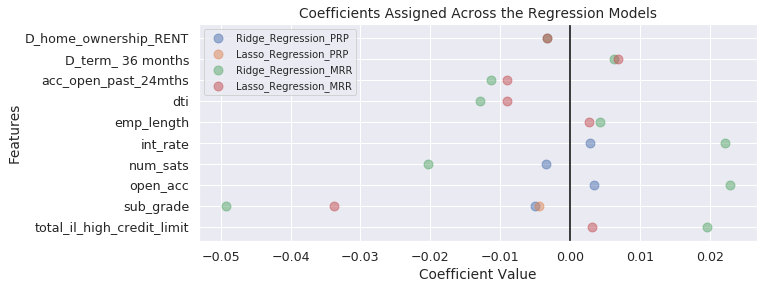

In [14]:
models = dict(Ridge_Regression_PRP=ridge_reg_PRP,
              Lasso_Regression_PRP=lasso_reg_PRP,
              Ridge_Regression_MRR=ridge_reg_MRR,
              Lasso_Regression_MRR=lasso_reg_MRR)
coefs2 = plot_coefficients(X_train_scaled, models=models, thresh=(0.0025,3), title='Regression Models')

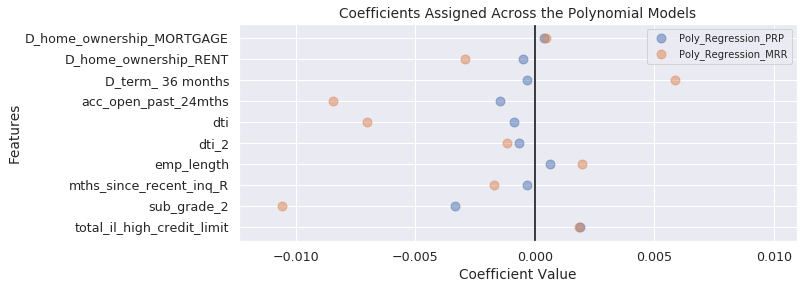

In [15]:
models = dict(
          Poly_Regression_PRP=lasso_reg2_PRP,
          Poly_Regression_MRR=lasso_reg2_MRR)
coefs3 = plot_coefficients(X_train_scaled_2, models=models, thresh=(0.0003,3), title='Polynomial Models')

## 2. Key Variables Driving Investment Decisions

The modeling has revealed key variables that should power the investment decisions: those which have significant coefficients across the distinct classification and regression models. These form the subset for our investment strategy formulation. This will aid interpretation and understanding for the investor at the loss of minimal investment efficacy. 

### 2A. Key Variables

In [16]:
key_variables = coefs2['coefs'].sort_values().reset_index(drop=True)
key_variables.name = 'key_variables'
X_train_key = X_train_scaled[key_variables]
print(key_variables)

0         D_home_ownership_RENT
1             D_term_ 36 months
2          acc_open_past_24mths
3                           dti
4                    emp_length
5                      int_rate
6                      num_sats
7                      open_acc
8                     sub_grade
9    total_il_high_credit_limit
Name: key_variables, dtype: object


### 2B. FULL Key Feature Decision Tree

With the key variables established, we examine decision tree and random forest analysis on this key subset to establish the investment strategy. We focus on the most comprehensive outcome feature of `OUT_Monthly_Rate_Of_Return` since this feature takes into account the total amount repeiad with interest for the effective term of the loan. We visualize both a larger tree (for completeness and demonstrative purposes) and a simplified tree. 

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=0.05, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')


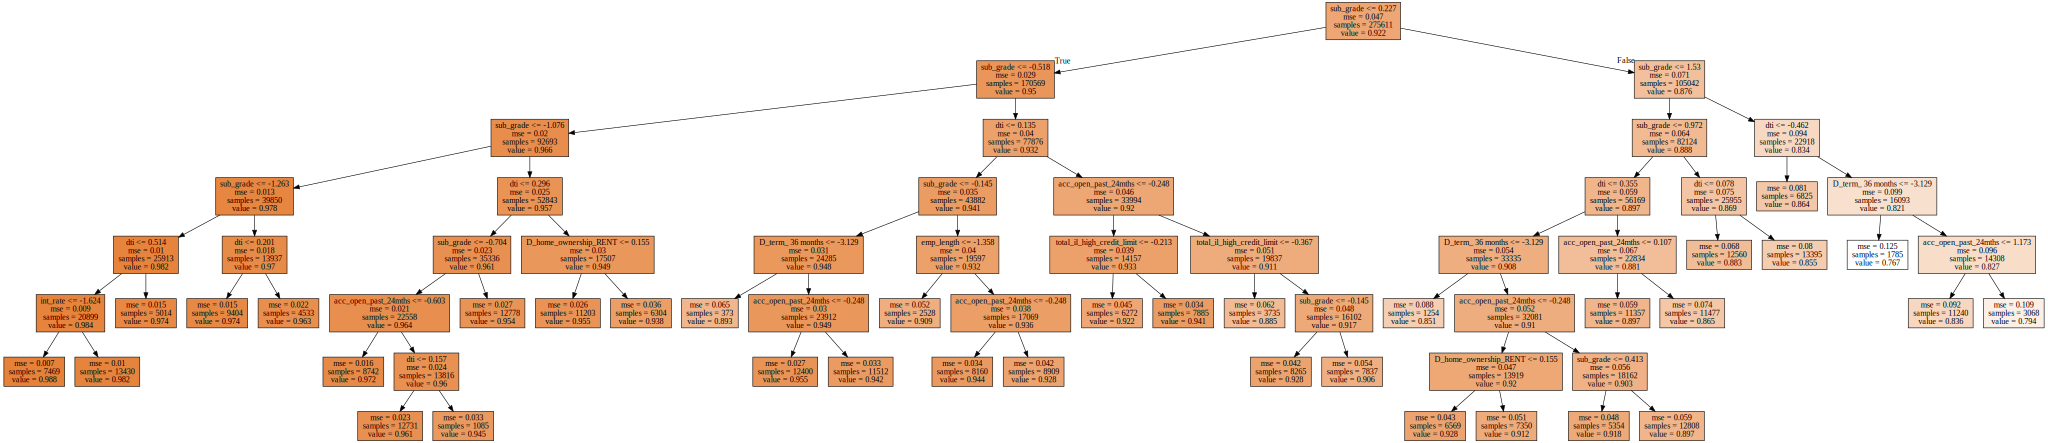

In [17]:
keydecisiontree = DecisionTreeRegressor(random_state=0, 
                                     max_depth=10, 
                                     min_samples_split=.05)
keydecisiontree.fit(X_train_key, OUT_Monthly_Rate_Of_Return_train)
print(keydecisiontree)
graph = Source(export_graphviz(keydecisiontree, 
                               feature_names=X_train_key.columns,
                               out_file=None, 
                               filled = True))
display(SVG(graph.pipe(format='svg')))
print()

### 2C. SIMPLIFIED Key Feature Decision Tree

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=0.05, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')


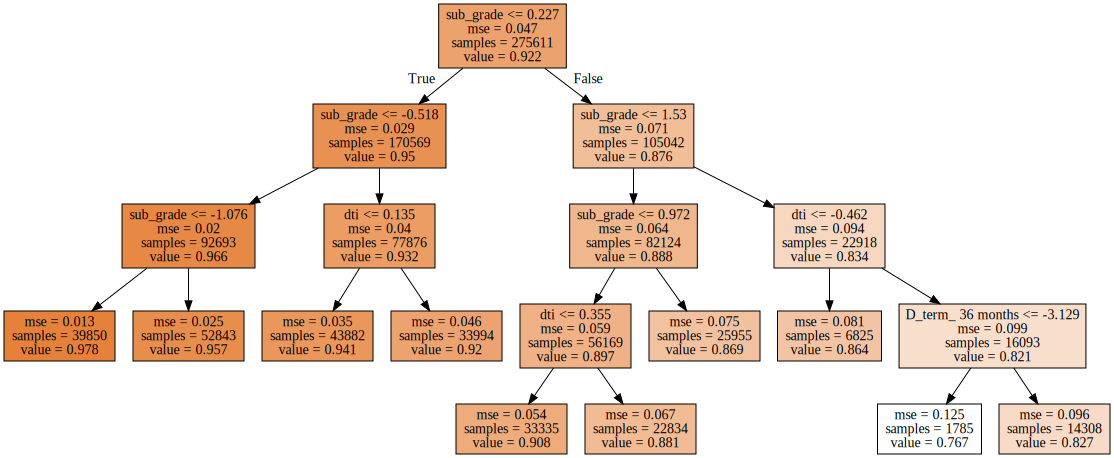

In [18]:
keydecisiontree = DecisionTreeRegressor(random_state=0, 
                                     max_depth=10, 
                                     min_samples_split=.05,
                                     max_leaf_nodes=10)
keydecisiontree.fit(X_train_key, OUT_Monthly_Rate_Of_Return_train)
print(keydecisiontree)
graph = Source(export_graphviz(keydecisiontree, 
                               feature_names=X_train_key.columns,
                               out_file=None, 
                               filled = True))
display(SVG(graph.pipe(format='svg')))
print()

### 2D. Key Feature Random Forest

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


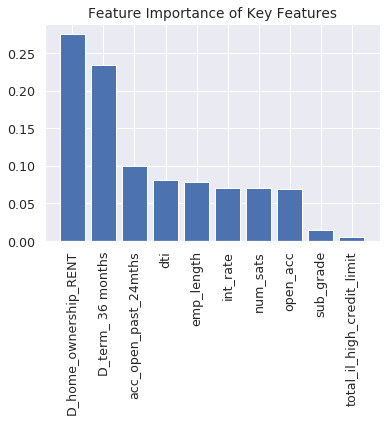

In [19]:
keyrandomforest = RandomForestRegressor(n_estimators=10)
keyrandomforest.fit(X_train_key, OUT_Monthly_Rate_Of_Return_train)

print(keyrandomforest)
importances = keyrandomforest.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature Importance of Key Features")
plt.bar(range(X_train_key.shape[1]), importances[indices])
plt.xticks(range(X_train_key.shape[1]), X_train_key.columns, rotation=90)
plt.show()

## 3. Investment Strategy

Based on the completed analysis, we postulate the following simple investment strategy to only invest in loans that meet the following criteria. To reduce risk and get the full benefit of diversification, we recommended that the mimimun qualifying investment should be made across as many qualifying loans as possible.

#### Non-Renter

Only invest in applications from non-renters.

In [20]:
non_renters = (ls['D_home_ownership_RENT'] == 0)

#### Shorter Term

Only invest in applications with term of 36 months.

In [21]:
short_term = (ls['D_term_ 36 months'] == 1)

#### Few Recent Accounts Opened

Only invest in applications from borrowers with less than 4 accounts opened in the last 24 months.

In [22]:
few_recent_accounts = (ls['acc_open_past_24mths'] < 4)

#### Low Debt-to-Income Ratio

Only invest in applications from borrowers with debt-to-equity ratios of less than 20%.

In [23]:
low_dti = (ls['dti'] < 20)

#### Solidly Employed

Only invest in applications from borrowers who have been employed over 5 years.

In [24]:
solid_emp = (ls['emp_length'] > 5)

#### Low Grade

Only invest in loans of grade A, B, C or D

In [25]:
low_grade = (ls['sub_grade'] <= 20)

## 4. Predictive Quality of Strategy

Our predictive strategy reduces the size of potential applications to about 9.6% of loans.

In [26]:
strategy = non_renters & short_term & few_recent_accounts & low_dti & solid_emp & low_grade

In [27]:
total = len(ls)
print('Non-Renter: {:.2%} of all loans'.format(sum(non_renters)/total))
print('Shorter Term: {:.2%} of all loans'.format(sum(short_term)/total))
print('Few Recent Accounts Opened: {:.2%} of all loans'.format(sum(few_recent_accounts)/total))
print('Low Debt-to-Income Ratio: {:.2%} of all loans'.format(sum(low_dti)/total))
print('Solidly Employed: {:.2%} of all loans'.format(sum(solid_emp)/total))
print('Low Grade: {:.2%} of all loans'.format(sum(low_grade)/total))
print()
print('Full Strategy: {:.2%} of all loans'.format(sum(strategy)/total))

Non-Renter: 57.67% of all loans
Shorter Term: 97.63% of all loans
Few Recent Accounts Opened: 46.08% of all loans
Low Debt-to-Income Ratio: 62.89% of all loans
Solidly Employed: 51.27% of all loans
Low Grade: 95.75% of all loans

Full Strategy: 9.60% of all loans


In [29]:
random = np.random.choice(ls.index.values, size=len(strategy), replace=False)
outputs = ['OUT_Class', 'OUT_Principle_Repaid_Percentage', 'OUT_Monthly_Rate_Of_Return']

for i in range(3):
    mean_strategy = np.mean(ls[outputs[i]][strategy])
    mean_random = np.mean(ls[outputs[i]][random])
    median_strategy = np.median(ls[outputs[i]][strategy])
    median_random = np.median(ls[outputs[i]][random])
    
    print(outputs[i])
    print('\tStrategy Mean: {:.4} \n\tRandom Mean: {:.4}'.format(mean_strategy, mean_random))
    if i == 2:
        print('\tStrategy Median: {:.4} \n\tRandom Median: {:.4}'.format(median_strategy, median_random))
    print()

OUT_Class
	Strategy Mean: 0.925 
	Random Mean: 0.8645

OUT_Principle_Repaid_Percentage
	Strategy Mean: 0.9593 
	Random Mean: 0.922

OUT_Monthly_Rate_Of_Return
	Strategy Mean: 0.002064 
	Random Mean: -0.001205
	Strategy Median: 0.005432 
	Random Median: 0.006085



The strategy performs well across all of the outcome metrics. 

- The investor can expect 92.5% of loans to be fully repaid, versus 86.5% from investing randomly, a gain of 6%.
- The investor can expect 95.9% of principle to be repaid, versus 92.3% from investing randomly, a gain of 3%.
- The investor can expect a mean monthly return of 0.20% and median monthly return of 0.61%